# Replicating Previous Visualizations in Dash

In [14]:
from jupyter_dash import JupyterDash
from dash import Dash, html, dcc, Input, Output
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pandas as pd
import numpy as np
from dateutil.parser import parse

## Data Loading and Preprocessing

In [15]:
with open("C:/Users/mjwan/Documents/Jobs/applied_8_9_2022.txt", "r", encoding="utf-8") as file:
    text = file.readlines()

# filter job lines
date_dict = {}

for line in text:
    try: 
        date = parse(line)
        date_dict[date] = []
    except:
        if ":" in line:
            date_dict[date].append(line)

jobs_by_date = [item for sublist in [list(map(lambda vv: (k, vv), v)) for k, v in date_dict.items()] for item in sublist]

In [16]:
DOW_dict = {"Monday": 0,
           "Tuesday": 1,
           "Wednesday": 2,
           "Thursday": 3,
           "Friday": 4,
           "Saturday": 5,
           "Sunday": 6}

df = pd.DataFrame(jobs_by_date, columns=["Date_Applied", "Line"])
df["Company"] = df["Line"].str.strip().str.split(":").apply(lambda l: l[0].strip())
df["Title"] = df["Line"].str.strip().str.split(":|w.+\$$|==>", regex=True).apply(lambda l: l[1].strip().title())
df["Result"] = df["Line"].str.strip().str.split("==>").apply(lambda l: l[1].strip().title() if len(l) > 1 else "No Response")
df["DOW"] = df["Date_Applied"].apply(lambda d: d.day_name())
df["year_month"] = df["Date_Applied"].dt.to_period("M").astype(str)

df_title = df["Title"]

dse_match = "(?i)Data Scientist|Data Science|Science|Scientist"
da_match = "(?i)Data Analyst|Data Analytics|Analytics|Analyst"
ml_match = "(?i)Machine Learning Engineer|Machine Learning"
de_match = "(?i)Data Engineer|Engineer|Engineering|Database"

# fixing overlaps
dse_series = df_title[df_title.str.contains(dse_match)]

ml_series = df_title[df_title.str.contains(ml_match)]
de_series = df_title[df_title.str.contains(de_match)]
de_series = de_series[(~de_series.isin(ml_series)) & (~de_series.isin(dse_series))]

da_series = df_title[df_title.str.contains(da_match)]
da_series = da_series[(~da_series.isin(dse_series)) & (~da_series.isin(de_series)) & (~da_series.isin(ml_series))]

other_series = df_title[~((df_title.str.contains(dse_match)) | (df_title.str.contains(da_match)) | (df_title.str.contains(ml_match)) | (df_title.str.contains(de_match)))]

df["Broad_Role"] = pd.Series("Data Scientist", dse_series.index).combine_first(pd.Series("Data Analyst", da_series.index)) \
    .combine_first(pd.Series("Data Engineer", de_series.index)) \
    .combine_first(pd.Series("ML Engineer", ml_series.index)) \
    .combine_first(pd.Series("Other", other_series.index))

## Save Dataframe to .csv (need to re-run when new results come in)

In [17]:
df.drop(["Line", "Title", "Company"], axis=1).to_csv("Application_Results_12_31_2022.csv")

## Constructing Dash Application

In [18]:
external_stylesheets = ['']

date_count = df.groupby("Date_Applied").size().reindex(pd.date_range(df["Date_Applied"].min(), df["Date_Applied"].max()), fill_value=0)

app = JupyterDash(__name__) #external_stylesheets=external_stylesheets)

# Result color map
result_colors = {
              "Total": "blue",
              "No Response": "salmon",  
              "Rejected": "crimson",
              "Contacted": "gold",
              "First Interview": "seagreen",
              "Second Intervew": "mediumseagreen",
              "Third Interview": "mediumaquamarine",
              "Offer": "lime",
              "Scam": "purple"
}

# bar graph role groupby
role_group = df.groupby(["Broad_Role", "Result"]).size().unstack()

role_group["Total"] = role_group.sum(axis=1)

role_group_to_bar = role_group.assign(temp_sum=role_group.sum(axis=1)) \
    .sort_values(by="temp_sum", ascending=False).iloc[:,:-1] \
    .reindex(role_group.mean(axis=0).sort_values(ascending=False).index, axis=1)

role_group_fig = px.bar(role_group_to_bar,
            barmode="group",
            color_discrete_map=result_colors,
            labels=dict(Broad_Role="Broad Role Category", 
                        value="# of Applications"),
            title="Application Results by Role Category"
            )

time_series_fig = make_subplots(specs=[[{"secondary_y": True}]])

time_series_fig.add_bar(x=date_count.index, y=date_count.values, name="Daily Count", secondary_y=False)

time_series_fig.add_scatter(x=date_count.cumsum().index, y=date_count.cumsum().values, name="Cumulative Count", fillcolor="orange", secondary_y=True)

time_series_fig.update_layout(yaxis_range=[date_count.min(),date_count.max()+1], title_text="Applications Over Time")
time_series_fig.update_yaxes(title_text="# of Applications Per Day", secondary_y=False)
time_series_fig.update_yaxes(title_text="Cumulative # of Applications", secondary_y=True)

# adding vertical lines
resume_dates = ["2022-08-12", "2022-08-19", "2022-08-31", "2022-09-05"]
interview_dates = df["Date_Applied"][df["Result"].str.contains("(?i)Interview")].values
offer_dates = df["Date_Applied"][df["Result"].str.contains("Offer")].values

for i, x in enumerate(resume_dates):
    #time_series_fig.add_vline(x=str(x), line_width=1, line_dash="dash", line_color="red")
    time_series_fig.add_trace(go.Scatter(x=[str(x),str(x)], 
                         y=[date_count.min(),date_count.max()+1], 
                         mode='lines', 
                         line=dict(color='red', width=2, dash='dash'),
                         name="Resume Updated",
                         legendgroup="Resume Updated",
                         showlegend=False if i > 0 else True))

for i, x in enumerate(interview_dates):
    #time_series_fig.add_vline(x=str(x), line_width=1, line_dash="dashdot", line_color="green")
    time_series_fig.add_trace(go.Scatter(x=[str(x),str(x)], 
                         y=[date_count.min(),date_count.max()+1], 
                         mode='lines', 
                         line=dict(color='green', width=1, dash='dashdot'),
                         name="Application(s) Led to Interview",
                         legendgroup="Application(s) Led to Interview",
                         showlegend=False if i > 0 else True))
    
for i, x in enumerate(offer_dates):
    #time_series_fig.add_vline(x=str(x), line_width=1, line_dash="longdashdot", line_color="black")
    time_series_fig.add_trace(go.Scatter(x=[str(x),str(x)], 
                     y=[date_count.min(),date_count.max()+1], 
                     mode='lines', 
                     line=dict(color='black', width=1, dash='longdashdot'),
                     name="Application(s) Led to Offer",
                     legendgroup="Application(s) Led to Offer",
                     showlegend=False if i > 0 else True))
    
pie_fig = px.pie(df, values=df["Result"].value_counts(), names=df["Result"].value_counts().index,
                color=df["Result"].value_counts().index,
                color_discrete_map=result_colors)    

pie_fig.update_layout(title=dict(text="Overall Applications", xanchor="center", x=0.5), font=dict(size=12))

# dow    
dow_group = df.groupby(["DOW", "Result"]).size().unstack() \
            .sort_index(key=lambda d: d.map(DOW_dict)) \

dow_group["Total"] = dow_group.sum(axis=1)

dow_group = dow_group.reindex(dow_group.mean(axis=0) \
            .sort_values(ascending=False).index, axis=1)

dow_fig = px.bar(dow_group,
            barmode="group",
            color_discrete_map=result_colors,
            labels=dict(DOW="Day of Application", 
                        value="# of Applications"),
            title="Application Results by Day of the Week"
            )   

# month
month_group = df.groupby(["year_month", "Result"]).size().unstack()

month_group["Total"] = month_group.sum(axis=1)

month_group = month_group.reindex(month_group.mean(axis=0) \
              .sort_values(ascending=False).index, axis=1)

month_fig = px.bar(month_group,
            barmode="group",
            color_discrete_map=result_colors,
            labels=dict(year_month="Month", 
                        value="# of Applications"),
            title="Application Results by Month"
            )  

month_fig.update_xaxes(
    dtick="M1",
    tickformat="%b %Y")    
    
app.layout = html.Div(children=[
    html.H1(children='Journey to an Entry-Level Job'),

    html.Div(children=[
        html.H2("""Background"""),
        
        html.P("""bigman""")
    
    ]),
    
    html.Div(children=[
        html.H2("""Examining Applications over Time"""),
        
        html.P("""The date range of applications I will look at is 08/09/2022 to 12/31/2022, bigman"""),
        
        dcc.Graph(
            id='time-series',
            figure=time_series_fig
        )
    
    ]),
    
    html.Div(children=[
        html.H2("""Examining Applications by Month"""),
        
        # "error loading layout": plotly doesn't like Period type for time?
        dcc.Graph(
            id='month-groups',
            figure=month_fig
        )
    ]),
    
    html.Div(children=[
        html.H2("""Examining Applications by Days of the Week"""),
        
        dcc.Graph(
            id='dow-groups',
            figure=dow_fig
        )
    ]),
    
    html.Div(children=[
        html.H2("""Examining Applications by Role"""),

        dcc.Graph(
            id='role-groups',
            figure=role_group_fig
        )
    ]),
    
    html.Div(children=[
        html.H2("""Overall Results of Applications"""),
        
        html.P("""guy"""),
        
        
        html.Div(children=[
            html.H4("""Role Category Dropdown"""),

            dcc.Dropdown(
                ["Overall"] + list(role_group_to_bar.index),
                'Overall',
                id='pie-cats'
            ),
                        
        ], style={'width': '25%'}),
        
        dcc.Graph(
            id='results-pie',
            figure=pie_fig
        )
    ]),
    html.Div(children=[
        html.H2("""In Conclusion..."""),
        
        html.P(""" """)
    ])
])

# callback decorator

@app.callback(
    Output('results-pie', 'figure'),
    Input('pie-cats', 'value'))
    
def update_pie(pie_category):   
    pie_category = pie_category if pie_category is not None else "Overall"
    
    # default to overall if clearing the dropdown
    if pie_category == "Overall":
        fig = px.pie(df, values=df["Result"].value_counts(), names=df["Result"].value_counts().index,
                color=df["Result"].value_counts().index,
                color_discrete_map=result_colors,
                hole=0.4) # donut
    else:
        pie_cat_df = df[df["Broad_Role"] == pie_category]
    
        fig = px.pie(pie_cat_df, values=pie_cat_df["Result"].value_counts(), names=pie_cat_df["Result"].value_counts().index,
                color=pie_cat_df["Result"].value_counts().index,
                color_discrete_map=result_colors,
                hole=0.4) # donut
    
    # update text labels on pie slices
    fig.update_traces(textinfo="value+percent", texttemplate="(%{value})<br>%{percent}")
    
    # update title
    fig.update_layout(title=dict(text=f"{pie_category} Applications", xanchor="center", x=0.5), font=dict(size=12))
    
    return fig
        
# when in script
#if __name__ == '__main__':
#    app.run_server()

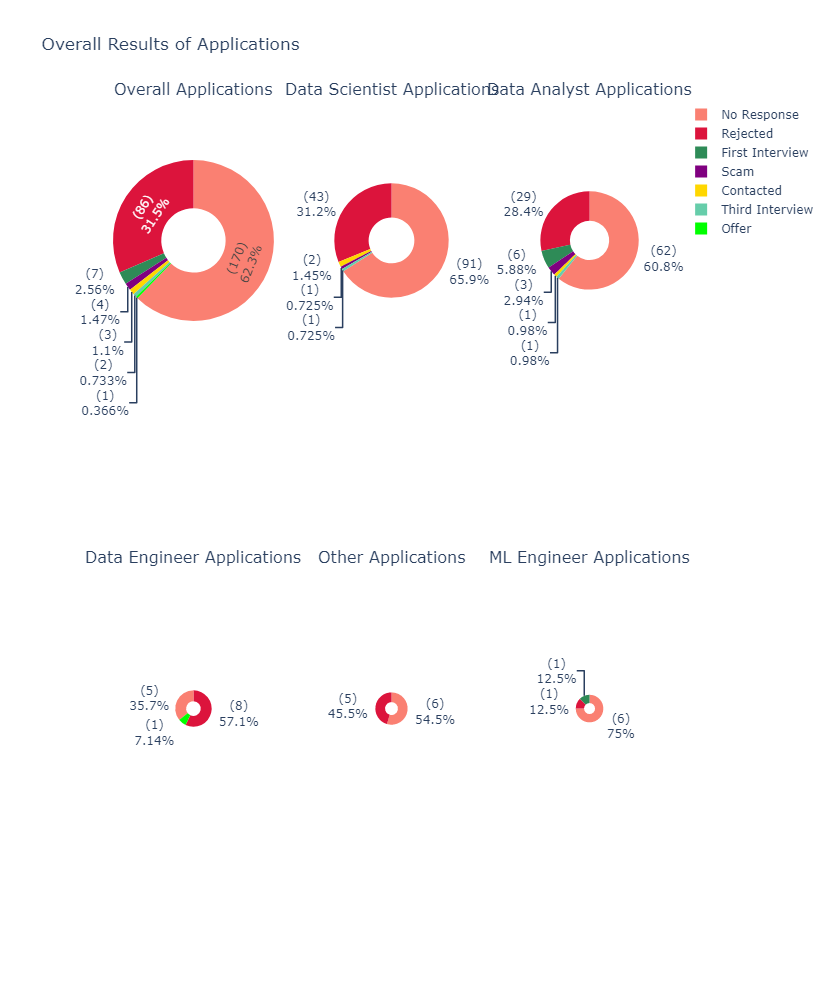

In [81]:
cats = ["Overall"] + list(role_group_to_bar.index)

fig = make_subplots(2, 3, subplot_titles=[cat + " Applications" for cat in cats], specs=[[{'type':'domain'}]*(len(cats) // 2), [{'type':'domain'}]*(len(cats) // 2)])
                   
s = pd.Series(result_colors).drop("Total").reindex(role_group_to_bar.drop("Total", axis=1).columns)
    
i, j = 1, 1
for pie_category in cats:
    
    pie_category = pie_category if pie_category is not None else "Overall"
   
    if pie_category == "Overall":
        fig.add_trace(go.Pie(values=df["Result"].value_counts(), 
                    labels=df["Result"].value_counts().index,
                    marker=dict(colors=s.reindex(df["Result"].value_counts().index)),
                    scalegroup='one',
                    hole=0.4,
                    name=""), i, j) 
    else:
        pie_cat_df = df[df["Broad_Role"] == pie_category]
    
        fig.add_trace(go.Pie(values=pie_cat_df["Result"].value_counts(), 
                labels=pie_cat_df["Result"].value_counts().index,
                scalegroup='one',
                marker=dict(colors=s.reindex(pie_cat_df["Result"].value_counts().index)),
                hole=0.4,
                name=""), i, j) # donut
    
    # update text labels on pie slices
    fig.update_traces(textinfo="value+percent", texttemplate="(%{value})<br>%{percent}")
    
    i = i if j < 3 else 2
    j = j + 1 if j < 3 else 1
    
fig.update_layout(width=1200, height=1000, title_text='Overall Results of Applications')
fig.show()

In [6]:
app.run_server(mode='jupyterlab', debug=False)

 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [12/Jan/2023 11:07:23] "GET /_alive_4f45a1f5-d683-4df8-a510-5e78809ede8d HTTP/1.1" 200 -


In [30]:
np.shape([[{'type': 'domain'}]*4, [{'type': 'domain'}]*4])

(2, 4)

In [38]:
np.shape([[{'type':'domain'}]*(len(cats) // 2), [{'type':'domain'}]*(len(cats) // 2)])

(2, 3)

In [63]:
role_group_to_bar.drop("Total", axis=1)

Result,No Response,Rejected,First Interview,Scam,Contacted,Offer,Third Interview
Broad_Role,,,,,,,
Data Scientist,91.0,43.0,NaN,1.0,2.0,NaN,1.0
Data Analyst,62.0,29.0,6.0,3.0,1.0,NaN,1.0
Data Engineer,5.0,8.0,NaN,NaN,NaN,1.0,NaN
Other,6.0,5.0,NaN,NaN,NaN,NaN,NaN
ML Engineer,6.0,1.0,1.0,NaN,NaN,NaN,NaN


In [70]:
s.drop("Total").reindex(role_group_to_bar.drop("Total", axis=1).columns)

Result
No Response                  salmon
Rejected                    crimson
First Interview            seagreen
Scam                         purple
Contacted                      gold
Offer                          lime
Third Interview    mediumaquamarine
dtype: object